In [58]:
! pip install shap

In [113]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import shap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso, Ridge

 # Paris Housing

In [21]:
data = pd.read_csv('C:/Users/ripea/Downloads/ParisHousing.csv')

In [5]:
data.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


In [34]:
X = data.drop('price', axis =1)
y = data['price']

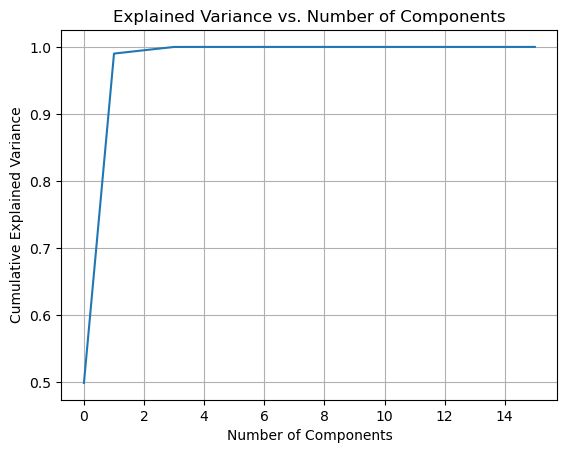

In [52]:
# Применение PCA ко всему датасету
pca_base = PCA().fit(X)

# Визуализация
plt.figure()
plt.plot(np.cumsum(pca_base.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(7000, 16) (3000, 16) (7000,) (3000,)


In [38]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae_without_pca = mean_absolute_error(y_test, y_pred)
print(f'MAE без снижения размерности: {mae_without_pca:.4f}')

MAE без снижения размерности: 1485.2080


In [46]:
pca = PCA(n_components=2) # уменьшаем до 2 компонент
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [47]:
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)

y_pred_pca = model_pca.predict(X_test_pca)

mae_with_pca = mean_absolute_error(y_test, y_pred_pca)
print(f'MAE с использованием PCA: {mae_with_pca:.4f}')

MAE с использованием PCA: 2632.5947


C:\Users\ripea\AppData\Local\Temp\ipykernel_24032\97106704.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 3))


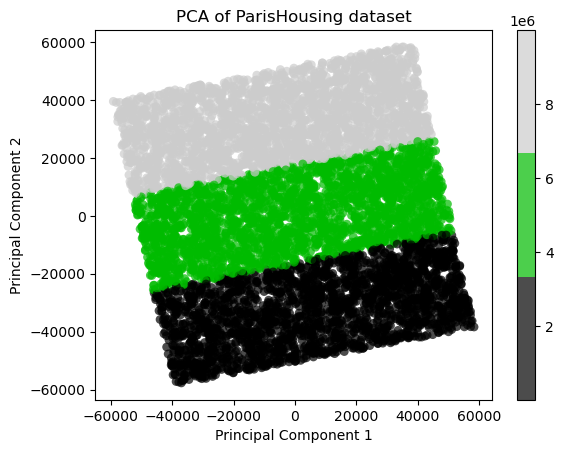

In [48]:
# Визуализация
plt.figure()
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 3))
plt.colorbar()
plt.title('PCA of ParisHousing dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [49]:
# Нормализация данных
scaler = StandardScaler()
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_train_pca_scaled

X_test_pca_scaled = scaler.fit_transform(X_test_pca)
X_test_pca_scaled

array([[-0.6938954 ,  0.85671075],
       [ 0.3621107 , -0.4124221 ],
       [ 0.89153516,  1.38528532],
       ...,
       [-1.26229536, -0.21535487],
       [ 0.11029739,  0.28817005],
       [-1.56830721, -0.41277045]])

In [50]:
v = pd.DataFrame(X_train_pca_scaled) 
v.describe().round(2)

,0,1
count,7000.00,7000.00
mean,-0.00,-0.00
std,1.00,1.00
min,-2.04,-2.02
25%,-0.86,-0.83
50%,0.00,-0.00
75%,0.86,0.83
max,2.02,2.04


In [54]:
model_pca_scaled = LinearRegression()
model_pca_scaled.fit(X_train_pca_scaled, y_train)
y_pred_pca_scaled = model_pca_scaled.predict(X_test_pca_scaled)
print(f"PCA-based Logistic Regression MAE: {mean_absolute_error(y_test, y_pred_pca_scaled):.2f}")

PCA-based Logistic Regression MAE: 156959.98


In [55]:
# добавление константы для перехвата
X_x = add_constant(data.drop('price', axis=1))

# расчет VIF для каждого предиктора
VIFs = pd.DataFrame()
VIFs['Variable'] = X_x.columns
VIFs['VIF'] = [variance_inflation_factor(X_x.values, i) for i in range(X_x.shape[1])]
print(VIFs)

             Variable           VIF
0               const  46469.639276
1        squareMeters      1.001078
2       numberOfRooms      1.002577
3             hasYard      1.000891
4             hasPool      1.001134
5              floors      1.001253
6            cityCode      1.000527
7       cityPartRange      1.001019
8       numPrevOwners      1.002557
9                made      1.000634
10         isNewBuilt      1.001623
11  hasStormProtector      1.000363
12           basement      1.001274
13              attic      1.001191
14             garage      1.002810
15     hasStorageRoom      1.002822
16       hasGuestRoom      1.002379


### нет проблем с мультиколлинеарностью (все значения меньше 5)

In [61]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

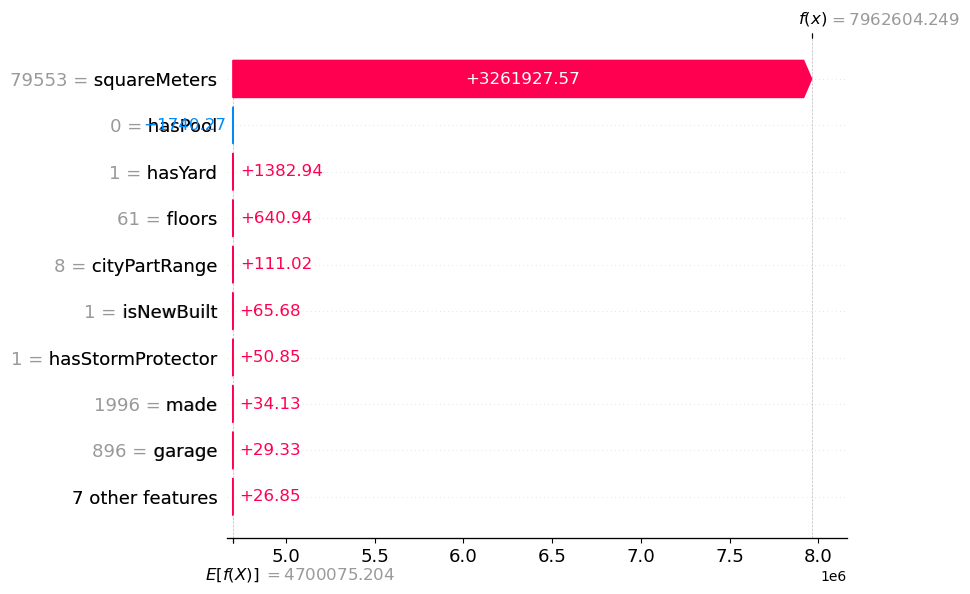

In [66]:
shap.plots.waterfall(shap_values[0])

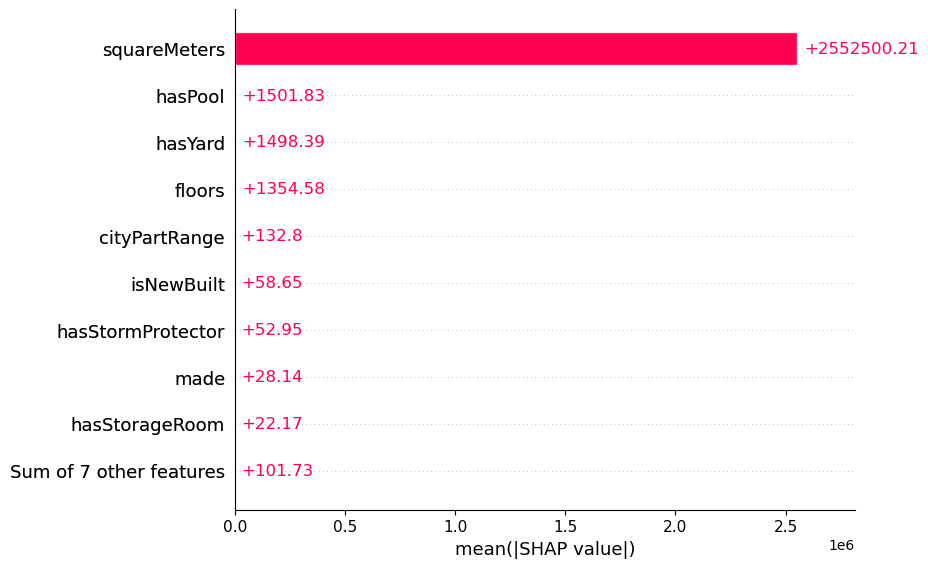

In [65]:
shap.plots.bar(shap_values)

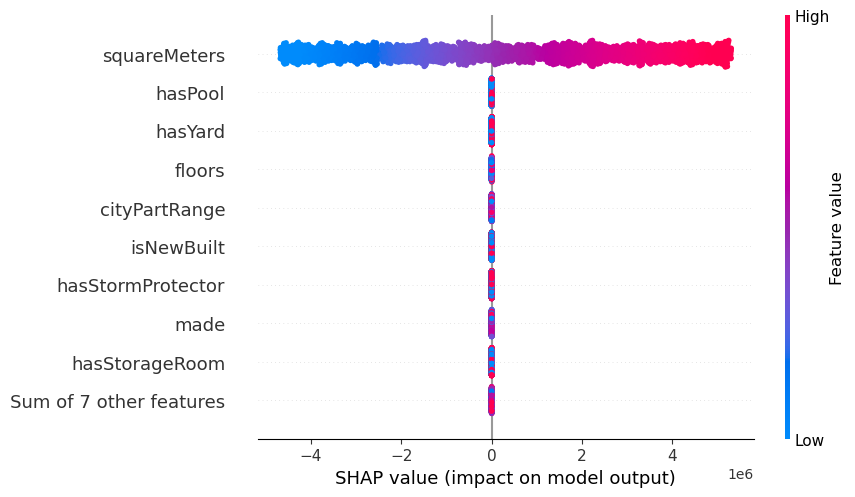

In [67]:
shap.plots.beeswarm(shap_values)

# Loan Data

In [80]:
loan_data_df = pd.read_csv('C:/Users/ripea/Downloads/loan_data.csv')

In [91]:
for column in loan_data_df.select_dtypes(include=['object']).columns:
    loan_data_df[column], unique = pd.factorize(loan_data_df[column])

loan_data_df.fillna(loan_data_df.mean(), inplace=True)

In [92]:
loan_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  int64  
 2   person_education                45000 non-null  int64  
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  int64  
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  int64  
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [93]:
loan_data_df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,0,0,71948.0,0,0,35000.0,0,16.02,0.49,3.0,561,0,1
1,21.0,0,1,12282.0,0,1,1000.0,1,11.14,0.08,2.0,504,1,0
2,25.0,0,1,12438.0,3,2,5500.0,2,12.87,0.44,3.0,635,0,1
3,23.0,0,2,79753.0,0,0,35000.0,2,15.23,0.44,2.0,675,0,1
4,24.0,1,0,66135.0,1,0,35000.0,2,14.27,0.53,4.0,586,0,1


In [124]:
y = loan_data_df['loan_status']
X = loan_data_df.drop("loan_status", axis = 1)

In [125]:
unique_classes = np.unique(y)
unique_classes

array([0, 1], dtype=int64)

In [126]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [127]:
# 2. Применение LDA
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

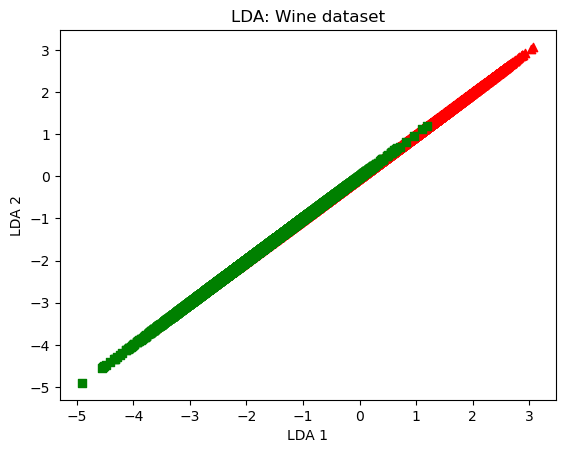

In [103]:
plt.figure()
for label, marker, color in zip(range(2), ('^', 's'), ('red', 'green')):
    plt.scatter(X_train_lda[y_train == label, 0],
                X_train_lda[y_train == label, 0],
                marker=marker, color=color)
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.title('LDA: Wine dataset')
plt.show()

In [128]:
lr = LogisticRegression()
lr.fit(X_train_lda, y_train)
y_pred = lr.predict(X_test_lda)
print(f"LDA-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.2f}")

LDA-based Logistic Regression Accuracy: 0.89


In [112]:
# добавление константы для перехвата
X_load_data = add_constant(loan_data_df.drop('loan_status', axis=1))

# расчет VIF для каждого предиктора
VIFs = pd.DataFrame()
VIFs['Variable'] = X_load_data.columns
VIFs['VIF'] = [variance_inflation_factor(X_load_data.values, i) for i in range(X_load_data.shape[1])]
print(VIFs)

                          Variable         VIF
0                            const  382.243360
1                       person_age   14.132289
2                    person_gender    1.000545
3                 person_education    1.003795
4                    person_income    1.443599
5                   person_emp_exp   11.274260
6            person_home_ownership    1.149391
7                        loan_amnt    2.187334
8                      loan_intent    1.003653
9                    loan_int_rate    1.075111
10             loan_percent_income    2.202099
11      cb_person_cred_hist_length    3.927744
12                    credit_score    1.074801
13  previous_loan_defaults_on_file    1.128951


### проблемка person_age, person_emp_exp

In [121]:
pls = PLSRegression(n_components=3)
X_train_pls = pls.fit_transform(X_train, y_train)[0]
X_test_pls = pls.transform(X_test)
lr_pls = LogisticRegression()
lr_pls.fit(X_train_pls, y_train)
y_pred_pls = lr_pls.predict(X_test_pls)
print(f"LDA-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_pls):.2f}")

LDA-based Logistic Regression Accuracy: 0.89


In [122]:
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# предположим, data — это DataFrame с предикторами
vif_info = calculate_vif(loan_data_df)
high_vif = vif_info[vif_info['VIF'] > 10]  # Установите порог, например 10
new_loan_data_df = loan_data_df.drop(columns=high_vif['feature'])

In [139]:
y = new_loan_data_df['loan_status']
X = new_loan_data_df.drop("loan_status", axis = 1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

new_lr = LogisticRegression()
new_lr.fit(X_train_lda, y_train)
y_pred = new_lr.predict(X_test_lda)
print(f"LDA-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.2f}")

LDA-based Logistic Regression Accuracy: 0.86


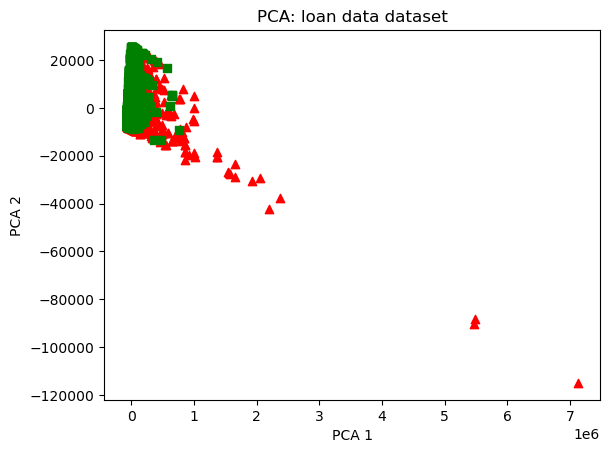

In [129]:
# 4. Сравнение с PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure()
for label, marker, color in zip(range(3), ('^', 's', 'o'), ('red', 'green', 'blue')):
    plt.scatter(X_train_pca[y_train == label, 0],
                X_train_pca[y_train == label, 1],
                marker=marker, color=color)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA: loan data dataset')
plt.show()

In [130]:
lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)
print(f"PCA-based Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_pca):.2f}")


PCA-based Logistic Regression Accuracy: 0.79


In [131]:
explainer = shap.Explainer(lr_pca, X_train_pca)
shap_values = explainer(X_test_pca)

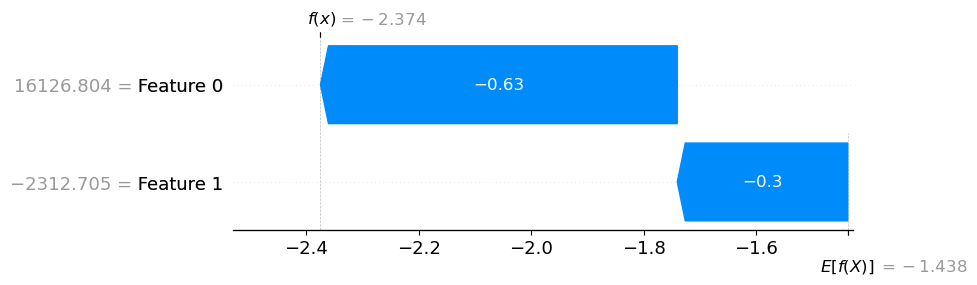

In [132]:
shap.plots.waterfall(shap_values[0])

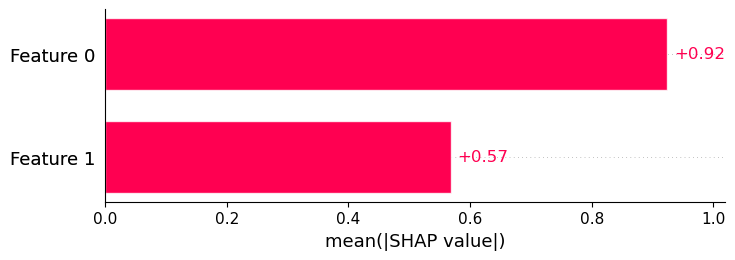

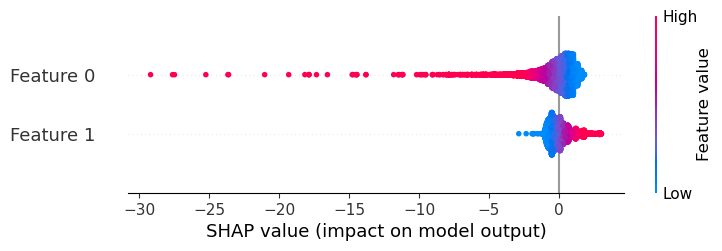

In [133]:
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)

In [134]:
explainer = shap.Explainer(new_lr, X_train_lda)
shap_values = explainer(X_test_lda)

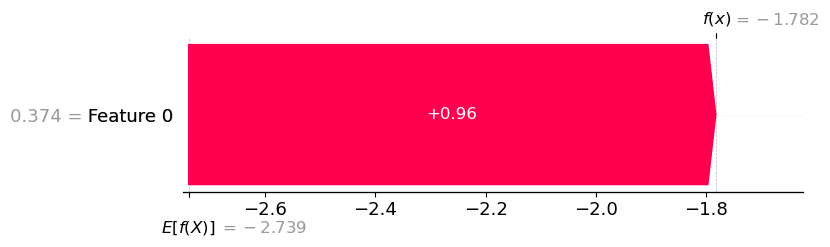

In [135]:
shap.plots.waterfall(shap_values[0])

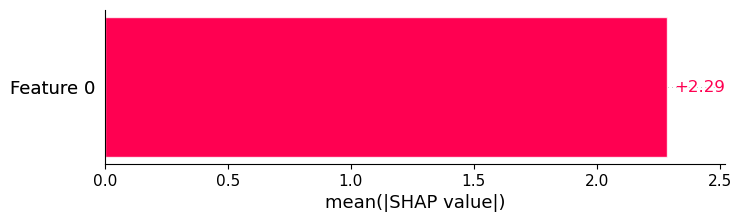

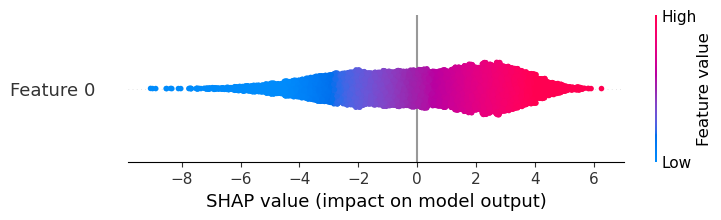

In [136]:
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)

## вывод: оценка муьтиколлинеарности и использование шап для оценки влияния признаков, снижение размерности, визуализация с помощью шап